In [ ]:
# Import helper functions
from tools import load_config, load_excel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from drug_data import typo_corrections, drug_categories
from collections import Counter



# Load configuration
config = load_config("config.yaml")

# Extract variables
data_location = config["data_location"]

# Load data
data = load_excel(data_location)

c:\Users\Danylo\Desktop\MainCategories\MastersDiploma\Practice\program\src\config.yaml


In [2]:
data.head()

,No,Sex,"Вік, років",Age1 (m),Age2 (d),Weight,Height,Vomiting,Freq. min,Freq. max,...,ORS type,Inf,Infus type (name),Z,Препарат цинку,AD,Adtype,AB,Name of antibiotic,Кількість ліжко-днів
0,1,2,0,4,22,4.9,60.0,1,2.0,3.0,...,New oralit,Yes,RL,Y,Zinckid,N,NaN,NaN,NaN,3
1,2,1,1,10,22,6.4,69.0,1,3.0,4.0,...,New oralit,Yes,RL,Y,Zinckid,N,NaN,NaN,NaN,3
2,3,1,1,10,13,13.0,82.0,2,NaN,NaN,...,New oralit,Yes,RL,Y,Zinckid,N,NaN,NaN,NaN,5
3,4,2,0,7,27,7.0,65.0,1,2.0,3.0,...,New oralit,Yes,RL,Y,Zinckid,Y,"Paracetamol 3x1/2 cth (if 57,38,5 C)",N,NaN,2
4,5,1,1,2,15,8.3,68.0,2,NaN,NaN,...,New oralit,Yes,others,Y,zincjid,Y,"Paracetamol 3xcm I_x000D_\nDiaxepam 2,5mg if c...",Y,Cefixim simp,3


In [3]:
data.columns

Index(['No', 'Sex', 'Вік, років', 'Age1 (m)', 'Age2 (d)', 'Weight', 'Height',
       'Vomiting', 'Freq. min', 'Freq.  max', 'Temperature', 'Dehydration',
       'Ротавірус', 'ORS', 'ORS type', 'Inf', 'Infus type (name)', 'Z',
       'Препарат цинку', 'AD', 'Adtype', 'AB', 'Name of antibiotic',
       'Кількість ліжко-днів'],
      dtype='object')

In [4]:
len(data)

840

In [5]:
from tools import load_config

# Attempt to load the configuration
try:
    config = load_config("config.yaml")
    print("Config loaded successfully!")
    print(config)
except FileNotFoundError as e:
    print(f"File not found: {e}")
except RuntimeError as e:
    print(f"YAML Error: {e}")

Config loaded successfully!
{'data_location': 'data/rotavirus_data.xlsx', 'download_url': 'https://example.com/rotavirus_data.xlsx'}


In [6]:
# Renaming columns to shorter names
short_renamed_columns = {
    'No': 'subjid',
    'Sex': 'sex',
    'Вік, років': 'agey',
    'Age1 (m)': 'agem',
    'Age2 (d)': 'aged',
    'Weight': 'weight',
    'Height': 'height',
    'Vomiting': 'vomitfrq',
    'Freq. min': 'vomit_minfrq',
    'Freq.  max': 'vomit_maxfrq',
    'ORS': 'orsfl',
    'ORS type': 'orstype',
    'Inf': 'inffl',
    'Infus type (name)': 'inftype',
    'Z': 'zincfl',
    'Препарат цинку': 'ztype',
    'AD': 'adrug',
    'Adtype': 'adrugtype',
    'AB': 'antibfl',
    'Name of antibiotic': 'antibtype',
    'Кількість ліжко-днів': 'hosp_days',
    'Ротавірус': 'virusfl',
    'Temperature': 'temp',
    "Dehydration": 'dehsev'
}

# Apply the renaming
data.rename(columns=short_renamed_columns, inplace=True)

# Display the first few rows to verify
print(data.head())


   subjid  sex  agey  agem  aged  weight  height  vomitfrq  vomit_minfrq  \
0       1    2     0     4    22     4.9    60.0         1           2.0   
1       2    1     1    10    22     6.4    69.0         1           3.0   
2       3    1     1    10    13    13.0    82.0         2           NaN   
3       4    2     0     7    27     7.0    65.0         1           2.0   
4       5    1     1     2    15     8.3    68.0         2           NaN   

   vomit_maxfrq  ...     orstype inffl inftype zincfl    ztype adrug  \
0           3.0  ...  New oralit   Yes      RL      Y  Zinckid     N   
1           4.0  ...  New oralit   Yes      RL      Y  Zinckid     N   
2           NaN  ...  New oralit   Yes      RL      Y  Zinckid     N   
3           3.0  ...  New oralit   Yes      RL      Y  Zinckid     Y   
4           NaN  ...  New oralit   Yes  others      Y  zincjid     Y   

                                           adrugtype antibfl     antibtype  \
0                               

In [7]:
data.columns

Index(['subjid', 'sex', 'agey', 'agem', 'aged', 'weight', 'height', 'vomitfrq',
       'vomit_minfrq', 'vomit_maxfrq', 'temp', 'dehsev', 'virusfl', 'orsfl',
       'orstype', 'inffl', 'inftype', 'zincfl', 'ztype', 'adrug', 'adrugtype',
       'antibfl', 'antibtype', 'hosp_days'],
      dtype='object')

In [8]:
# Function to recode FL columns
def recode_fl_columns(df):
    # Identify all columns ending with 'fl'
    fl_columns = [col for col in df.columns if col.endswith('fl')]
    for col in fl_columns:
        df[col] = df[col].apply(lambda x: 1 if str(x).strip().lower() in ['yes', 'y', 'true', '1'] else 0)
    return df

# Apply the function to recode FL columns
data = recode_fl_columns(data)

# Display the first few rows to verify
print(data.head())


   subjid  sex  agey  agem  aged  weight  height  vomitfrq  vomit_minfrq  \
0       1    2     0     4    22     4.9    60.0         1           2.0   
1       2    1     1    10    22     6.4    69.0         1           3.0   
2       3    1     1    10    13    13.0    82.0         2           NaN   
3       4    2     0     7    27     7.0    65.0         1           2.0   
4       5    1     1     2    15     8.3    68.0         2           NaN   

   vomit_maxfrq  ...     orstype inffl  inftype  zincfl    ztype  adrug  \
0           3.0  ...  New oralit     1       RL       1  Zinckid      N   
1           4.0  ...  New oralit     1       RL       1  Zinckid      N   
2           NaN  ...  New oralit     1       RL       1  Zinckid      N   
3           3.0  ...  New oralit     1       RL       1  Zinckid      Y   
4           NaN  ...  New oralit     1   others       1  zincjid      Y   

                                           adrugtype  antibfl     antibtype  \
0            

In [9]:
unique_values = data['dehsev'].unique()
unique_values


array(['Severe dehydration', 'Mild dehydration', 'No dehydration', nan],
      dtype=object)

In [10]:
# Count the number of NaN values in 'dehsev'
nan_count = data['dehsev'].isna().sum()

# Display the count
print(f"Number of NaN values in 'dehsev': {nan_count}")


Number of NaN values in 'dehsev': 4


In [11]:
data[data['dehsev'].isna()]

,subjid,sex,agey,agem,aged,weight,height,vomitfrq,vomit_minfrq,vomit_maxfrq,...,orstype,inffl,inftype,zincfl,ztype,adrug,adrugtype,antibfl,antibtype,hosp_days
708,850,2,0,2,14,2.5,50.0,1,1.0,2.0,...,Oralit,1,KaEN,1,Zinckid,Y,Cefotaxim _x000D_\nGentamicin _x000D_\nSanmol ...,0,NaN,33
759,902,1,0,11,1,9.5,87.0,2,NaN,NaN,...,NaN,0,NaN,0,NaN,N,NaN,0,NaN,2
761,904,1,1,5,28,10.0,71.0,2,NaN,NaN,...,NaN,0,NaN,1,Zinckid,Y,Ampicilin_x000D_\nClirolanfenicol_x000D_\nDiam...,0,NaN,10
781,924,1,1,3,0,6.2,62.0,1,1.0,3.0,...,New oralit,0,NaN,0,NaN,Y,Ceftriaxone 2x300mg,0,NaN,9


In [12]:
print(f"Rows before dropping NaN: {len(data)}")

# Drop rows with NaN in 'dehsev'
data = data.dropna(subset=['dehsev'])

# Verify that the rows were dropped
print(f"Remaining rows after dropping NaN: {len(data)}")


Rows before dropping NaN: 840
Remaining rows after dropping NaN: 836


In [13]:
# Check unique values in the 'adrugtype' column
unique_adrugtype = data['adrugtype'].unique()
print(unique_adrugtype)

[nan 'Paracetamol 3x1/2 cth (if 57,38,5 C)'
 'Paracetamol 3xcm I_x000D_\nDiaxepam 2,5mg if convulsions_x000D_\nCefotaxim 4x400mg'
 'Probiotik' 'Dialac 3x1 sachet_x000D_\nParacetamol 3x1_x000D_\n'
 'koreksi kel 7.46% 30 mg dlm 1000ml_x000D_\nRL 24_x000D_\nKce Pulws 3x275mg po'
 'Domperidon _x000D_\nParacetamol_x000D_\n'
 'cloramfenicol_x000D_\nampicillin_x000D_\n' 'Kci pulvus 3x250 mg po'
 'domperidon syr 3xcm1/2' 'AB: Ampicillin_x000D_\ngentamicyn'
 'Ampicillin 4x250 g N_x000D_\nCefotaxime 3x250 g N' 'Ambroxce syr'
 'Cotrimoxazole 2x1 cth' 'Ampicillin 4x150g' 'Cotrimoxazole 2x15 I'
 'Ampicillin' 'Ampicillin IV'
 'cefotaxime_x000D_\nbolus RL_x000D_\nparacetamol' 'Probiotil 1x1 sachet'
 'parascetamol_x000D_\n' 'cotrimoxazole_x000D_\nmetromidazole'
 'paracetamol 3x1/2cg_x000D_\nprobiotik' 'parasetamol 3xcg I'
 'parasetamol' 'lacto B_x000D_\n' 'cerobxum' 'ampicilin'
 'ampicilin 4x800_x000D_\ncerobxum 3x800' 'paracetamol syr'
 'Rehidrasi dg Resomal_x000D_\nAmpicillin 4x300mg IV_x000D_\nGent

In [14]:
# Clean the 'adrugtype' column
data['adrugtype'] = data['adrugtype'].str.replace('_x000D_', '', regex=False)
data['adrugtype'] = data['adrugtype'].str.replace('\n', ' ', regex=False)
data['adrugtype'] = data['adrugtype'].str.strip()  # Remove leading/trailing spaces


In [15]:
# Print unique values in 'adrugtype'
unique_adrugtype = data['adrugtype'].unique()
print(unique_adrugtype)


[nan 'Paracetamol 3x1/2 cth (if 57,38,5 C)'
 'Paracetamol 3xcm I Diaxepam 2,5mg if convulsions Cefotaxim 4x400mg'
 'Probiotik' 'Dialac 3x1 sachet Paracetamol 3x1'
 'koreksi kel 7.46% 30 mg dlm 1000ml RL 24 Kce Pulws 3x275mg po'
 'Domperidon  Paracetamol' 'cloramfenicol ampicillin'
 'Kci pulvus 3x250 mg po' 'domperidon syr 3xcm1/2'
 'AB: Ampicillin gentamicyn' 'Ampicillin 4x250 g N Cefotaxime 3x250 g N'
 'Ambroxce syr' 'Cotrimoxazole 2x1 cth' 'Ampicillin 4x150g'
 'Cotrimoxazole 2x15 I' 'Ampicillin' 'Ampicillin IV'
 'cefotaxime bolus RL paracetamol' 'Probiotil 1x1 sachet' 'parascetamol'
 'cotrimoxazole metromidazole' 'paracetamol 3x1/2cg probiotik'
 'parasetamol 3xcg I' 'parasetamol' 'lacto B' 'cerobxum' 'ampicilin'
 'ampicilin 4x800 cerobxum 3x800' 'paracetamol syr'
 'Rehidrasi dg Resomal Ampicillin 4x300mg IV Gentamicin 1x50 mg IV Vit A 200000 IV Vit C 1x1, As Folat 1x5mg hari I'
 'Paracetamol syrup 3x1/2 cth' 'Kotri 2xcth II p.o'
 'Paracetamol syr 3x1 cth' '02 21lm Diazepam supp 10mg'

In [16]:
import re

# Assuming 'data' is your DataFrame with the 'adrugtype' column
# Uncomment and modify the following line if you need to load your data from a CSV file
# data = pd.read_csv('your_data.csv')  # Replace 'your_data.csv' with your actual file name

# Step 1: Define Typo Corrections and Drug Categories


def clean_text(text):
    """
    Clean the input text by converting to lowercase, removing special characters,
    and normalizing whitespace.
    """
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', ' ', text)  # Remove special characters except letters and spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Replace multiple spaces with a single space
    return text

def correct_typos(text):
    """
    Correct common typos and variations in drug names using the typo_corrections dictionary.
    """
    words = text.split()
    corrected_words = []
    i = 0
    while i < len(words):
        word = words[i]
        # Check for two-word drugs
        if i < len(words) - 1:
            two_word = f"{words[i]} {words[i + 1]}"
            if two_word in typo_corrections:
                corrected_words.append(typo_corrections[two_word])
                i += 2
                continue
        # Correct single-word typos
        corrected_word = typo_corrections.get(word, word)
        corrected_words.append(corrected_word)
        i += 1
    return ' '.join(corrected_words)

# Create a set of all drug names for matching
drug_names = set(drug_categories.keys())

def extract_drugs(text):
    """
    Extract drug names from the input text by matching words against known drug names.
    Handles both single-word and two-word drug names.
    """
    found_drugs = set()
    words = text.split()
    i = 0
    while i < len(words):
        word = words[i]
        # Check for two-word drug names
        if i < len(words) - 1:
            two_word = f"{words[i]} {words[i + 1]}"
            if two_word in drug_names:
                found_drugs.add(two_word)
                i += 2
                continue
        # Check for single-word drug names
        if word in drug_names:
            found_drugs.add(word)
        i += 1
    return list(found_drugs)

def map_drugs_to_categories(drugs):
    """
    Map each drug in the list to its corresponding category.
    """
    categories = set()
    for drug in drugs:
        category = drug_categories.get(drug)
        if category:
            categories.add(category)
    return list(categories)

def process_categories(data):
    # Initialize an empty list to store the drug categories for each row
    drug_categories_list = []

    for _, row in data.iterrows():
        # Clean and process the 'adrugtype' column
        cleaned_text = clean_text(row['adrugtype']) if pd.notna(row['adrugtype']) else ''
        corrected_text = correct_typos(cleaned_text)
        extracted_drugs = extract_drugs(corrected_text)
        categories = map_drugs_to_categories(extracted_drugs)

        # Append the unique categories as a list of strings
        drug_categories_list.append(list(set(categories)))

    # Add the new column to the original dataset
    data['drug_category'] = drug_categories_list

    return data

# Apply the processing function
data = process_categories(data)


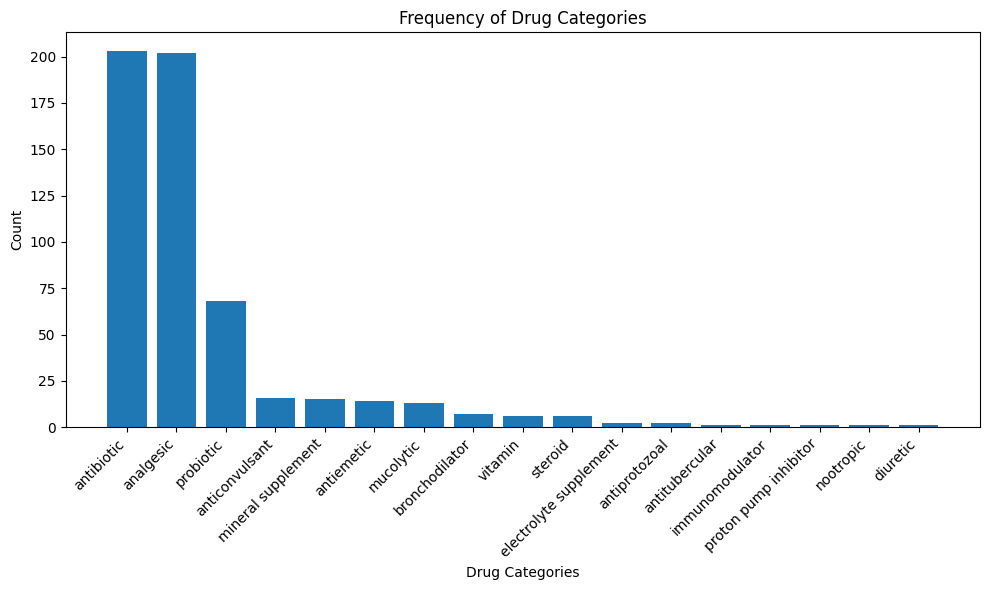

In [ ]:
from collections import Counter

# Flatten the list of categories into a single list
category_counts = Counter(cat for categories in data['drug_category'] for cat in categories)

# Sort the categories by frequency
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)

# Separate the keys and values for plotting
categories, counts = zip(*sorted_categories)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, counts)
plt.xlabel('Drug Categories')
plt.ylabel('Count')
plt.title('Frequency of Drug Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
len(data[data['categories']==None])

0

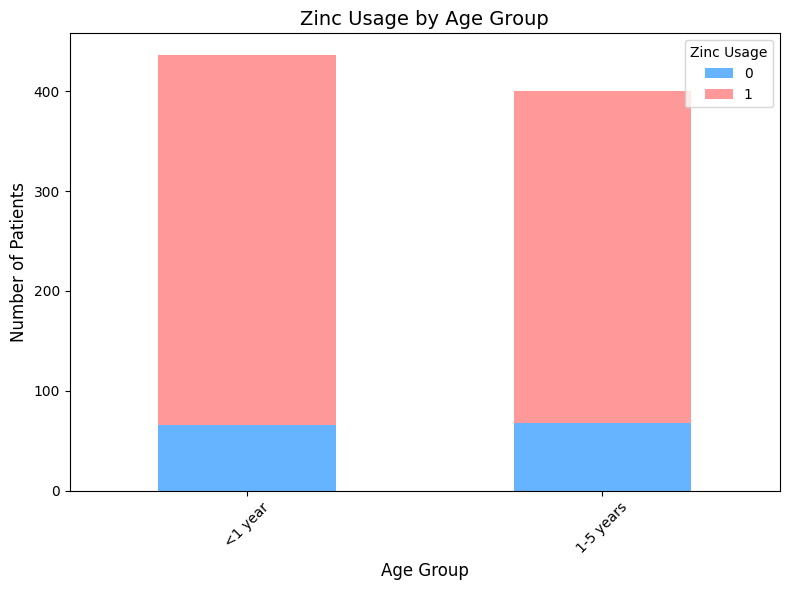

In [26]:
# Combine age into a single variable (e.g., convert months and days to years)
data['age_years'] = data['agey'] + data['agem'] / 12 + data['aged'] / 365

# Define age groups
bins = [0, 1, 5, 10, 18]  # Adjust bins as needed
labels = ['<1 year', '1-5 years', '5-10 years', '10-18 years']
data['age_group'] = pd.cut(data['age_years'], bins=bins, labels=labels)

# Crosstab of zinc usage by age group
zinc_age = pd.crosstab(data['age_group'], data['zincfl'])

# Plot
zinc_age.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#66b3ff', '#ff9999'])

plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.title('Zinc Usage by Age Group', fontsize=14)
plt.legend(title='Zinc Usage', loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[1 0]


C:\Users\Danylo\AppData\Local\Temp\ipykernel_24580\3629976446.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Rotavirus Status', y='Count', data=virus_status_counts, palette='coolwarm')


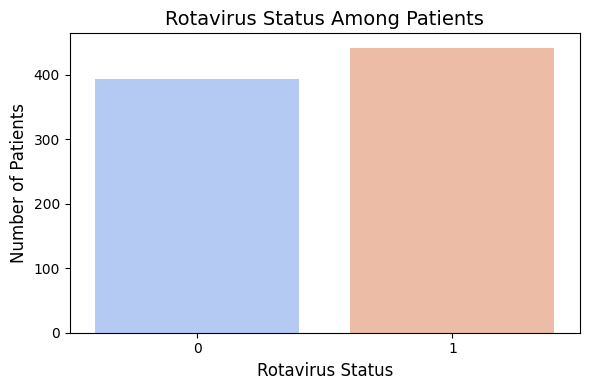

In [27]:

# Assuming 'data' is your DataFrame and 'virusfl' indicates rotavirus status

# First, check the unique values in 'virusfl'
print(data['virusfl'].unique())

# If necessary, map the values to meaningful labels
# For example, if 'virusfl' contains 'Positive' and 'Negative', you can proceed directly
# If 'virusfl' contains codes like 1 for Positive and 0 for Negative, map them:
# data['virusfl'] = data['virusfl'].map({1: 'Positive', 0: 'Negative'})

# Count the number of patients in each category
virus_status_counts = data['virusfl'].value_counts().reset_index()
virus_status_counts.columns = ['Rotavirus Status', 'Count']

# Plot the bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='Rotavirus Status', y='Count', data=virus_status_counts, palette='coolwarm')

# Add labels and title
plt.xlabel('Rotavirus Status', fontsize=12)
plt.ylabel('Number of Patients', fontsize=12)
plt.title('Rotavirus Status Among Patients', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
data_exploded[data_exploded['categories'] == 'antibiotic']['adrugtype']

4      Paracetamol 3xcm I Diaxepam 2,5mg if convulsio...
15                              cloramfenicol ampicillin
18                             AB: Ampicillin gentamicyn
19             Ampicillin 4x250 g N Cefotaxime 3x250 g N
21                                 Cotrimoxazole 2x1 cth
                             ...                        
821         Inj Cefotaxim 3x200mg Inj Ampicillin 3x200mg
823    Salbutamol Ampicillin Chloramphenicol Nebu Pul...
827                                 Paracetamol Cefixime
829            zinc Dialac inj Cefotaxime inj ampicillin
834                        Ampicillin Cefotaxim Diazepam
Name: adrugtype, Length: 203, dtype: object

In [ ]:
data_exploded[data_exploded['categories'] == 'antibiotic']['adrugtype']


4      Paracetamol 3xcm I Diaxepam 2,5mg if convulsio...
15                              cloramfenicol ampicillin
18                             AB: Ampicillin gentamicyn
19             Ampicillin 4x250 g N Cefotaxime 3x250 g N
21                                 Cotrimoxazole 2x1 cth
                             ...                        
821         Inj Cefotaxim 3x200mg Inj Ampicillin 3x200mg
823    Salbutamol Ampicillin Chloramphenicol Nebu Pul...
827                                 Paracetamol Cefixime
829            zinc Dialac inj Cefotaxime inj ampicillin
834                        Ampicillin Cefotaxim Diazepam
Name: adrugtype, Length: 203, dtype: object

In [ ]:
# Select the 'adrugtype' entries where 'categories' is 'antibiotic'
antibiotic_adrugtype = data_exploded[data_exploded['categories'] == 'antibiotic']['adrugtype']


In [ ]:
# Write the data to a text file without the index and header
antibiotic_adrugtype.to_csv('antibiotic_adrugtype.txt', index=False, header=False)
